In [16]:
'''
Author: XiangxinZhong
Date: 2021-10-20 22:44:45
LastEditors: XiangxinZhong
LastEditTime: 2021-10-25 08:49:01
Description: 本模型主要由sigmod,梯度下降法函数,损失函数,输出函数,可视化函数组成，使用logistics模型解决了西瓜数据集和鸢尾花数据集的二分类问题
             并在基础模型上拓展，增加了模型评估,步长动态调节等功能.
'''

import numpy as np
from math import exp
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
import sklearn.metrics as mtc


#导入iris数据集,本次实验引入两类花，解决二分类问题,同时为了可视化，选择长宽两个特征
iris = load_iris()
setosa = iris.data[:50,:2] #花1
setosa_label = iris.target[:50]
versi = iris.data[50:100,:2] #花2
versi_label = iris.target[50:100] 
feat = np.r_[iris.data[:40,:2],iris.data[50:90,:2]]#训练集 特征
label = np.r_[iris.target[:40],iris.target[50:90]] #训练集label 
featTest = np.r_[iris.data[40:50,:2],iris.data[90:100,:2]] #测试集特征
labelTest = np.r_[iris.target[40:50],iris.target[90:100]] #测试集label

#西瓜数据集
data = pd.read_csv("watermelon_3a.csv")
feat = data.iloc[:,1:3].values
label = data.iloc[:,3].values
featTest = feat
labelTest = label

num = 17 #训练集样本数量

loss = [] #loss数组,记录loss的变化

'''
description: sigmoid函数，将函数值映射到(0,1)区间
param {*} X
return {*} 0 or 1.0/(1+exp(-X))
'''
def sigmoid(X):
    if (X < -100):
        return 0
    else:
        return 1.0/(1+exp(-X))

'''
description: 梯度下降函数,估计模型参数,首先使用极大似然法得到对数似然函数,然后用梯度下降法估计模型参数.
             公式推导在实验报告中给出,此处直接用推导结果.
param {*} feat
param {*} label
return {*} weights
'''
def calW(feat, label):
    loss.clear()
    label = label
    featMat = np.mat(feat)
    m,n = featMat.shape #m是样本数量，n是特征数量
    featMat = np.c_[featMat,np.ones((m,1))]
    m,n = featMat.shape #m是样本数量，n是特征数量
    weights = np.ones((n,1)) #参数初始为1
    epoch = 1000 #迭代次数
    for i in range(epoch):
        idx = np.arange(m)
        for j in range(m):
            lam = 0.0001 + 4/(1+i+j) #epoch增加，学习率降低
            randIdx = int(np.random.uniform(0,len(idx)))
            y_pre = sigmoid(np.sum(featMat[randIdx]*weights)) #预测值
            error = label[randIdx] - y_pre
            weights += lam*error*featMat[randIdx].transpose() #更新
            #idx = np.delete(idx,idx[randIdx])
        y_pre_arr = featMat.dot(weights)
        for i in range(len(y_pre_arr)):
            y_pre_arr[i] = sigmoid(y_pre_arr[i])
        y_pre_arr = y_pre_arr.round().flatten()
        loss_tmp = np.sum(abs(y_pre_arr - label))
        loss.append(loss_tmp)           
    return weights


'''
description: Batch Gradient Descent, 对比SGD
param {*} feat
param {*} label
return {*} weights
'''
def BGD(feat, label):
    loss.clear()
    label = label
    m,n = feat.shape #m是样本数量，n是特征数量
    feat = np.c_[feat,np.ones((m,1))]
    m,n = feat.shape #m是样本数量，n是特征数量
    weights = np.ones((n,1)) #参数初始为1
    epoch = 1000 #迭代次数
    lam = 0.01 #BGD采用固定学习率
    error = np.zeros((n,1))
    for i in range(epoch):
        y_pre = feat.dot(weights)
        for j in range(len(y_pre)):
            y_pre[j] = sigmoid(y_pre[j])
        y_pre = y_pre.round()
        loss.append(np.sum(y_pre-label))
        for j in range(len(label)):
            tmp = (label[j]-y_pre[j])*feat[j]
            tmp = tmp.reshape((3,1))
            error += tmp
        weights += (1/m)*lam*error
    return weights
    
    
'''
description: 画出分类结果，为了可视化仅选择两个特征作分类，在拓展部分增加特征数量
param {*} feat
param {*} label
param {*} weights
return {*} none
'''
def plotResult(feat,label,weights):
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    length = len(label)
    for i in range(length):
        if (label[i] == 1):
            x1.append(feat[i][0])
            y1.append(feat[i][1])
        else:
            x2.append(feat[i][0])
            y2.append(feat[i][1])
    plt.scatter(x1,y1,marker='o', c = 'b', s = 30, label = 'cat1')
    plt.scatter(x2,y2,marker='o', c = 'r', s = 50, label = 'cat2')
    plt.xlabel("Density")
    plt.ylabel("Sugar rate")
    plt.title("Watermelon Result")
    MINN = min(np.min(x1),np.min(x2))
    MAXX = max(np.max(x1),np.max(x2))
    x = np.arange(MINN,MAXX,0.1)
    y = (-weights[2]-weights[0]*x)/weights[1]
    plt.plot(x,y)
    plt.show()

'''
description: 使用sklearn.metrics评价模型表现,并打印结果
param {*} feat
param {*} weights
param {*} label
param {*} num
return {*}
'''
def printResult(feat,weights,label,num):
    featMat = np.c_[feat,np.ones((num,1))]
    y_pre = featMat.dot(weights)
    for i in range(len(y_pre)):
        y_pre[i] = sigmoid(y_pre[i])
    y_pre = y_pre.round().flatten()
    acc = mtc.accuracy_score(label,y_pre) 
    precision = mtc.precision_score(label, y_pre, labels=None, pos_label=1, average='binary') #查准率
    recall = mtc.recall_score(label, y_pre, labels=None, pos_label=1, average='binary', sample_weight=None) #查全率
    f1 = mtc.f1_score(label, y_pre, labels=None, pos_label=1, average='binary', sample_weight=None)
    Confusion = mtc.confusion_matrix(label,y_pre,labels=None, sample_weight=None, normalize=None)
    print("Accuracy: ", acc)
    print("Precision rate:", precision)
    print("Recall rate: ", recall)
    print("F1 score: ", f1)
    print("Confusion metrix: ", Confusion)
    
'''
description: 展示迭代过程loss的变化情况
param {*} loss
return {*} none
'''
def showLoss(loss):
    loss = loss[::10]
    length = len(loss)
    x = np.arange(length)
    plt.plot(x,loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

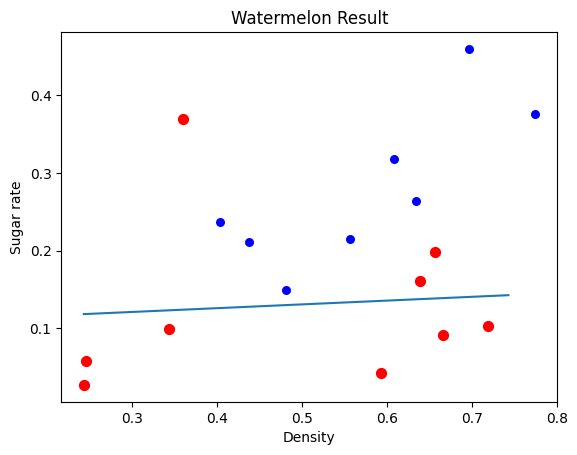

Accuracy:  0.8235294117647058
Precision rate: 0.7272727272727273
Recall rate:  1.0
F1 score:  0.8421052631578948
Confusion metrix:  [[6 3]
 [0 8]]


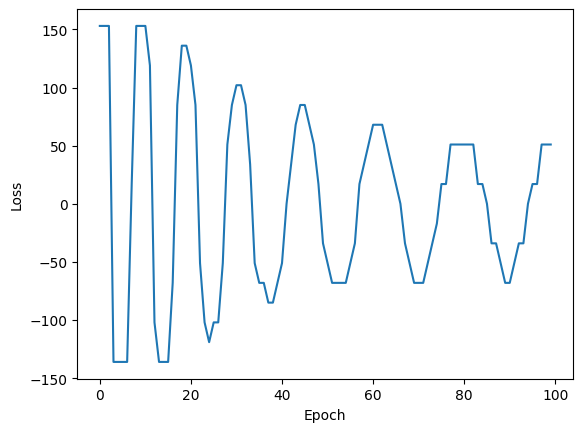

In [19]:
'''
description: 主函数
param {*}
return {*}
'''
if __name__ == "__main__":
    weights = BGD(feat,label)
    plotResult(featTest,labelTest,weights)
    printResult(featTest,weights,labelTest,num)
    showLoss(loss)
